# Обработка за 24 часа это хорошо

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sn
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:.2f}'.format
warnings.filterwarnings("ignore")

## Вспомогательные переменные

In [3]:
# Сегодняшний день
today = datetime.date.today()
# Даты промежутка отчёта
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-08-20')
# сейвер
archive_path_final_result =f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\24 часа\\Архив\\{today} Время принятия решения исходник.xlsx"

## Подгрузка исходников

In [4]:
# Загрузка файла рекламаций
raw_complaints = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\24 часа\\xxx.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')
# загрузка файла нетоварных обращений
raw_non_marketable = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\24 часа\\zzz.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')
# Чтение и загрузка ВПР, создание слоарей из файлов
# ЛЦ
VPR_compiaints_lines_lc = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР построчный ЛЦ.xlsx")
key_complaints_lines_lc = dict(zip(VPR_compiaints_lines_lc['Текст'], VPR_compiaints_lines_lc['Значение']))
# ЛЦ для нетоварных
VPR_non_marketable = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР нетоварные ЛЦ.xlsx")
key_non_marketable = dict(zip(VPR_non_marketable['Текст'], VPR_non_marketable['Значение']))
# Офис по должности для нетоварных
VPR_non_marketable_office = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР должность - офис.xlsx")
key_non_marketable_office = dict(zip(VPR_non_marketable_office['Текст'], VPR_non_marketable_office['Значение']))
# ЛЦ\РК
VPR_RK = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР ЛЦ РК.xlsx")
key_RK = dict(zip(VPR_RK['Текст'], VPR_RK['Значение']))
# Маркер этапа рекламации
VPR_complaints_stage_marker = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР рабочий маркер этапа.xlsx")
key_complaints_stage_marker = dict(zip(VPR_complaints_stage_marker['Текст'],
                                            VPR_complaints_stage_marker['Значение']))

In [5]:
len(raw_complaints)

374008

In [6]:
# Преобразование форматов времени рекламаций
raw_complaints[['Дата запуска процесса', 
                'Дата завершения процесса', 
                'Дата запуска текущего этапа']] = raw_complaints[[
                'Дата запуска процесса', 
                'Дата завершения процесса', 
                'Дата запуска текущего этапа']].apply(pd.to_datetime)

In [7]:
# Преобразование форматов времени нетоварных рекламаций
raw_non_marketable[['Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']] = raw_non_marketable[[
                    'Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']].apply(lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S'))

In [8]:
# Подтягиваю лц из словарика
def get_lc(row):
    if row['Должность менеджера из документа'] in key_complaints_lines_lc:
        return key_complaints_lines_lc[row['Должность менеджера из документа']]
    elif row['РК по документу'] in key_complaints_lines_lc:
        return key_complaints_lines_lc[row['РК по документу']]
    else:
        return None

raw_complaints['ЛЦ'] = raw_complaints.apply(get_lc, axis=1)

# Стедж маркер из словарика
def get_stage_marker2(row):
    if row['Текущий этап'] in key_complaints_stage_marker:
        return key_complaints_stage_marker[row['Текущий этап']]
    else:
        return None
raw_complaints['Маркер этапа'] = raw_complaints.apply(get_stage_marker2, axis=1)

complaints_pure = raw_complaints.drop(['Результат Возврата Товара',
                                          'Результат Замены Довоза'], axis=1)
# Порядок столбцов
complaints_lines_columns_order = ['Id процесса','РК по документу','ОП по складу',
                                  'Номер документа','Код к/а','Название к/а','ФИО к/а','Телефон к/а','Класс 71',
                                  'Класс 72','Менеджер из документа','Должность менеджера из документа','ЛЦ','Класс 55',
                                  'РК исполнителя этапа','Должность исполнителя этапа','Описание претензии',
                                  'Исполнитель текущего этапа','Текущий этап',
                                  'Дата запуска процесса','Дата завершения процесса',
                                  'Количество дней работы процесса','Дата запуска текущего этапа',
                                  'Количество часов отработки этапа процесса', 'Маркер этапа']
complaints_pure = complaints_pure.reindex(columns=complaints_lines_columns_order)

In [9]:

complaints_pure = complaints_pure.query('`Дата завершения процесса`.isnull() or `Дата завершения процесса` >= @start_date and `Дата завершения процесса` <= @end_date')


In [10]:
# Сортирую - Id процесса по возрастанию, Маркер этапа по убыванию
# Это нужно чтобы определить последний этап по каждому процессу, видеть дубликаты и подтянуть формулу которая 
# определит есть ли конечное решение
complaints_pure = complaints_pure.sort_values(['Id процесса', 'Маркер этапа'], ascending=[True, False]).reset_index()

In [11]:
# Определяю есть ли решение по  рекламации
def create_solution_column(complaints_pure):
    complaints_pure['Наличие решения'] = ''

    for index, row in complaints_pure.iterrows():
        if index != 0 and complaints_pure.at[index, 'Id процесса'] == complaints_pure.at[index-1, 'Id процесса']:
            complaints_pure.at[index, 'Наличие решения'] = complaints_pure.at[index-1, 'Наличие решения']
        elif row['Маркер этапа'] > 3:
             complaints_pure.at[index, 'Наличие решения'] = 'Есть решение'
        elif pd.isnull(row['Дата завершения процесса']):
            complaints_pure.at[index, 'Наличие решения'] = 'Нет решения'
        else:
            complaints_pure.at[index, 'Наличие решения'] = 'Есть решение'

    return complaints_pure
create_solution_column(complaints_pure)
complaints_pure.head(1)

,index,Id процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,ЛЦ,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Исполнитель текущего этапа,Текущий этап,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Маркер этапа,Наличие решения
0,375,2315543,"Директор по продажам РЦ Юруц СЗ,Директор по п...",Архангельск ОП1,129/2021410-3,55004312,Энерком-строй,Наталия,89115699120,0d3,~S,Фролов Кирилл,Сотрудник отдела Архангельск ОП1,СЗ,Э,NaN,NaN,"Запрос по качеству, количеству, цене товара",ELMA BOT,Таймер,2023-02-21,NaT,181,2023-02-21 11:24:21,4335,2.00,Нет решения


In [12]:
# cоздаю дубль на всякий случай, чтобы иметь возсожность проверить предыдущий этап
unique2_3 = complaints_pure

In [13]:
# делаю срез с "нет решения" эти даные не войдут в нынешний промежуток времени т.к. 
# по ним невозможно посчитать конечное время отработки процесса
unique2_3 = unique2_3.query("`Наличие решения` == 'Есть решение'")
# так же срезаю все этапы с номерами «3,9», «4», «4,1» т.к. они не входят в оцениваемыый параметр
# до них решение уше принято
unique2_3 = unique2_3.query("`Маркер этапа` == [2,3]")

In [14]:
# сортирую по убыванию количества часов отработки - это даст возможность сбосить дубли верно
unique2_3 = unique2_3.sort_values(['Количество часов отработки этапа процесса'], ascending=False)
# удаляю дубли
unique2_3.drop_duplicates(subset=['Id процесса','Текущий этап'], keep='first', inplace=True)

In [15]:
unique2_3['Количество часов отработки этапа процесса'].sum()

575447

In [16]:
# считаю количество дубликатов чтобы разделить рекламации на те в которых 1 строка и 2
unique2_3['Количество строк'] = unique2_3.groupby('Id процесса')['Id процесса'].transform('count')

### Один этап

In [17]:
# забираю все у которых 1 этап
one_stage = unique2_3.query("`Количество строк` == 1")

In [18]:
len(one_stage)

4613

In [19]:
# по этому столбцу таблицы соединятся в итоге, там будет скорректированное время
one_stage['Количество строк'] = one_stage['Количество часов отработки этапа процесса']
one_stage = one_stage.rename(columns=({'Количество строк':'2+3'}))


###  2 и 3 этап суммарное время

In [20]:

stage_2_plus_3 = unique2_3.query("`Количество строк` == 2")
stage_2_plus_3 = stage_2_plus_3.sort_values(['Id процесса', 'Маркер этапа'], ascending=[True, False])

In [21]:
len(stage_2_plus_3)

13232

In [22]:
sum_column = stage_2_plus_3.groupby('Id процесса')['Количество часов отработки этапа процесса'].sum()
sum_column 
# Создание нового столбца '2+3' и заполнение его значениями суммы
stage_2_plus_3 = stage_2_plus_3.query("`Маркер этапа` == 3")
stage_2_plus_3['2+3'] = stage_2_plus_3['Id процесса'].map(sum_column)


In [23]:
# Создание нового столбца '2+3' и заполнение его значениями суммы
stage_2_plus_3['2+3'] = stage_2_plus_3['Id процесса'].map(sum_column)
# Оставляем только по 1 маркеру этапа
stage_2_plus_3 = stage_2_plus_3.query("`Маркер этапа` == 3")
stage_2_plus_3 = stage_2_plus_3.drop('Количество строк', axis=1)


In [24]:
len(stage_2_plus_3)

6616

### Сложение этапов

In [25]:
# сливаю один этап и там где два по сумме часов
stage_2_plus_3 = pd.concat([stage_2_plus_3, one_stage])

In [26]:
# прибавляю к дате запуска прошедшее время чтобы понять когда было принято решение
stage_2_plus_3['Дата принятия решения'] = stage_2_plus_3[
    'Дата запуска процесса'] + pd.to_timedelta(stage_2_plus_3['2+3'], unit='hours')

In [27]:
# Вытаскиваю день недели для корректировок как везде тут счёт начинается с нуля - понедельник = 0
stage_2_plus_3['День недели заведения обращения'] = stage_2_plus_3[
    'Дата запуска процесса'].dt.weekday
stage_2_plus_3 = stage_2_plus_3.rename(columns={'2+3':'Время выполнения этапа'})

    0 : понедельник
    1 : вторник
    2 : среда
    3 : Четверг
    4 : пятница
    5 : суббота
    6 : воскресенье

### Здесь не учитываются праздники, нужно придумать как это сделать

In [28]:
# функции корректировки времени с чётом выходных дней и установки критериев
def adjustment_holidays(dataset):
    dataset['Корректировка времени с выходными днями'] = ''
    for index, row in dataset.iterrows():
        if row['День недели заведения обращения'] < 4:
            dataset.at[
                index, 'Корректировка времени с выходными днями'] = dataset.at[index, 'Время выполнения этапа']
        elif row['День недели заведения обращения'] == 4:
            dataset.at[
                index, 'Корректировка времени с выходными днями'] = dataset.at[index, 'Время выполнения этапа'] - 48
        elif row['День недели заведения обращения'] == 5:
            dataset.at[
                index, 'Корректировка времени с выходными днями'] = dataset.at[index, 'Время выполнения этапа'] - 32
        elif row['День недели заведения обращения'] == 6:
            dataset.at[
                index, 'Корректировка времени с выходными днями'] = dataset.at[index, 'Время выполнения этапа'] - 8
    return dataset
def criterion(dataset):
    dataset['Критерий'] = ''
    for index, row in dataset.iterrows():
        if row['Корректировка времени с выходными днями'] < 24:
            dataset.at[
                index, 'Критерий'] = 'до 24-х часов'
        else:
            dataset.at[
                index, 'Критерий'] = 'более 24-х часов'
    return dataset            

In [29]:
adjustment_holidays(stage_2_plus_3)
criterion(stage_2_plus_3)
stage_2_plus_3['Корректировка времени с выходными днями'].sum()

485487

In [30]:
len(stage_2_plus_3)

11229

In [31]:
raw_non_marketable.head(1)

,Id процесса,ФИО МОО по задаче CSI,CSI закрытия жалоб,Комментарий контролера CSI,Тип клиента,Требуется завести в ЦО повторно,Дата запуска,Дата завершения,Дата запуска текущего этапа,Дата закрытия текущего этапа,Отработан,ЦКГ клиента,ПодЦКГ клиента,РЦ структура,Состояние,Время выполнения этапа,РК,Город,УКОК,Склад/Офис,НОП,Должность НОП,Исполнитель,Ответивший клиенту,Должность ответившего,Офис ответившего,Код клиента,Имя клиента,ФИО клиента,Телефон клиента,Описание претензии,"Фактическая дата, указанная клиентом",Комментарий,E-mail клиента,Качество обслуживания,Дата ответа,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях,Анализ причин,Планируемые действия,Комментарий ИВК,Комментарий ДИСК,Комментарий ЦПП,Комментарий контролера,Категория обращения,Причина обращения 1,Детализация причины обращения 1,Причина обращения 2,Детализация причины обращения 2,Причина обращения 3,Детализация причины обращения 3,Категория компенсации,Выбор компенсаций,Вид компенсации Баллы/Сертификат,Сумма Баллов/Сертификата,Вид компенсации Промокод,Сумма Промокода,Вид компенсации Подарок из ассортимента,Сумма Подарка,Комментарий к компенсации,Сумма компенсации,Наличие отклонения,Отсутствие приветствия,Отсутствие благодарности,Отсутствие извинения,Отсутствие обратной связи,Отсутствие прощания
0,1462931,NaN,NaN,NaN,NaN,нет,2022-01-01 15:33:17,10.01.2022 9:01:02,2022-01-01 15:33:19,2022-01-10 09:00:52,NaN,NaN,NaN,"Директор по маркетингу, УЦПП",Ознакомиться с претензией,209,NaN,Санкт-Петербург,NaN,Центр поддержки продаж (ЦПП СПБ),Лопухова Анна,NaN,Лопухова Анна,NaN,NaN,NaN,1623186,Частное лицо,,NaN,По качеству обслуживания,2022-01-01,Что у вас с сайтом? Тоже с похмелья? Весь день...,8t210@mail.ru,0,NaT,"Добрый деньВасилий, спасибо за обращение. При ...",не треб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,нет,нет,нет,нет,нет


## Нетоварные обращения

In [32]:
# удаляю все ненужные столбцы
columns_to_drop = raw_non_marketable.columns[
    list(raw_non_marketable.columns).index('Комментарий о выполненных корректирующих мероприятиях') + 1:
]
raw_non_marketable = raw_non_marketable.drop(columns=columns_to_drop)
raw_non_marketable.head(1)

,Id процесса,ФИО МОО по задаче CSI,CSI закрытия жалоб,Комментарий контролера CSI,Тип клиента,Требуется завести в ЦО повторно,Дата запуска,Дата завершения,Дата запуска текущего этапа,Дата закрытия текущего этапа,Отработан,ЦКГ клиента,ПодЦКГ клиента,РЦ структура,Состояние,Время выполнения этапа,РК,Город,УКОК,Склад/Офис,НОП,Должность НОП,Исполнитель,Ответивший клиенту,Должность ответившего,Офис ответившего,Код клиента,Имя клиента,ФИО клиента,Телефон клиента,Описание претензии,"Фактическая дата, указанная клиентом",Комментарий,E-mail клиента,Качество обслуживания,Дата ответа,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях
0,1462931,NaN,NaN,NaN,NaN,нет,2022-01-01 15:33:17,10.01.2022 9:01:02,2022-01-01 15:33:19,2022-01-10 09:00:52,NaN,NaN,NaN,"Директор по маркетингу, УЦПП",Ознакомиться с претензией,209,NaN,Санкт-Петербург,NaN,Центр поддержки продаж (ЦПП СПБ),Лопухова Анна,NaN,Лопухова Анна,NaN,NaN,NaN,1623186,Частное лицо,,NaN,По качеству обслуживания,2022-01-01,Что у вас с сайтом? Тоже с похмелья? Весь день...,8t210@mail.ru,0,NaT,"Добрый деньВасилий, спасибо за обращение. При ...",не треб


In [33]:
def get_lc2(row):
    if row['Склад/Офис'] in key_non_marketable:
        return key_non_marketable[row['Склад/Офис']]
    else:
        return None
raw_non_marketable['ЛЦ'] = raw_non_marketable.apply(get_lc2, axis=1)
raw_non_marketable.insert(21, 'ЛЦ', raw_non_marketable.pop('ЛЦ'))

In [34]:
# Помечаю датасет как нетоварное для дальнейшего слияния
raw_non_marketable.insert(0, 'Вид обращения', '')
raw_non_marketable['Вид обращения'] = 'нетоварное'

In [35]:
raw_non_marketable = raw_non_marketable.rename(columns={'Отработан': 'День недели заведения обращения',
                                                        'ЦКГ клиента': 'Корректировка времени с выходными днями',
                                                         'ПодЦКГ клиента': 'Критерий', })
raw_non_marketable.head(1)

,Вид обращения,Id процесса,ФИО МОО по задаче CSI,CSI закрытия жалоб,Комментарий контролера CSI,Тип клиента,Требуется завести в ЦО повторно,Дата запуска,Дата завершения,Дата запуска текущего этапа,Дата закрытия текущего этапа,День недели заведения обращения,Корректировка времени с выходными днями,Критерий,РЦ структура,Состояние,Время выполнения этапа,РК,Город,УКОК,Склад/Офис,НОП,ЛЦ,Должность НОП,Исполнитель,Ответивший клиенту,Должность ответившего,Офис ответившего,Код клиента,Имя клиента,ФИО клиента,Телефон клиента,Описание претензии,"Фактическая дата, указанная клиентом",Комментарий,E-mail клиента,Качество обслуживания,Дата ответа,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях
0,нетоварное,1462931,NaN,NaN,NaN,NaN,нет,2022-01-01 15:33:17,10.01.2022 9:01:02,2022-01-01 15:33:19,2022-01-10 09:00:52,NaN,NaN,NaN,"Директор по маркетингу, УЦПП",Ознакомиться с претензией,209,NaN,Санкт-Петербург,NaN,Центр поддержки продаж (ЦПП СПБ),Лопухова Анна,ЦПП,NaN,Лопухова Анна,NaN,NaN,NaN,1623186,Частное лицо,,NaN,По качеству обслуживания,2022-01-01,Что у вас с сайтом? Тоже с похмелья? Весь день...,8t210@mail.ru,0,NaT,"Добрый деньВасилий, спасибо за обращение. При ...",не треб


In [36]:
right_status = ['Ознакомиться с претензией НОП', 'Ознакомиться с претензией ЦПП']
non_marketable_familiarize = raw_non_marketable[raw_non_marketable['Состояние'].isin(right_status)]
non_marketable_familiarize = non_marketable_familiarize.query(
    '`Дата ответа` >= @start_date and `Дата ответа` <= @end_date' )
non_marketable_familiarize = non_marketable_familiarize.sort_values(['Id процесса', 'Время выполнения этапа'], ascending=[True, False])
non_marketable_familiarize.drop_duplicates(subset='Id процесса', keep='first', inplace=True)

In [37]:
len(non_marketable_familiarize)

614

In [38]:
non_marketable_familiarize['День недели заведения обращения'] =  non_marketable_familiarize[
    'Дата запуска'].dt.weekday


In [39]:
adjustment_holidays(non_marketable_familiarize)
criterion(non_marketable_familiarize)
non_marketable_familiarize.head(1)

,Вид обращения,Id процесса,ФИО МОО по задаче CSI,CSI закрытия жалоб,Комментарий контролера CSI,Тип клиента,Требуется завести в ЦО повторно,Дата запуска,Дата завершения,Дата запуска текущего этапа,Дата закрытия текущего этапа,День недели заведения обращения,Корректировка времени с выходными днями,Критерий,РЦ структура,Состояние,Время выполнения этапа,РК,Город,УКОК,Склад/Офис,НОП,ЛЦ,Должность НОП,Исполнитель,Ответивший клиенту,Должность ответившего,Офис ответившего,Код клиента,Имя клиента,ФИО клиента,Телефон клиента,Описание претензии,"Фактическая дата, указанная клиентом",Комментарий,E-mail клиента,Качество обслуживания,Дата ответа,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях
23103,нетоварное,2514254,NaN,NaN,NaN,Юридическое лицо,нет,2023-06-07 16:27:47,18.08.2023 23:32:40,2023-06-07 16:27:00,2023-06-08 07:38:51,2,15,до 24-х часов,"Директор по продажам 2 РЦ Урал, Директор по п...",Ознакомиться с претензией НОП,15,Урал,Екатеринбург,Лопухова Анна,Екатеринбург ОП1,Христофоров Сергей,Урал,Сотрудник отдела Екатеринбург ОП1,Христофоров Сергей,Христофоров Сергей,Сотрудник отдела Екатеринбург ОП1,Екатеринбург ОП1,1406647,"ООО ""Инжениум Групп""",Яковлев Александр,79086301648.00,По качеству обслуживания,2023-06-07,Здравствуйте!Существует проблема с оформлением...,a.yakovlev@igroup.su,0,2023-08-17 12:59:52,Получен комментарий от специалистов: Благодари...,ожидаем реализации возможности нового способа ...


In [40]:
non_marketable_familiarize['Корректировка времени с выходными днями'].sum()

21016

## Титаническое слияние

In [41]:
merged_complains = stage_2_plus_3.query(
    '`Дата принятия решения` >= @start_date and `Дата принятия решения` <= @end_date' )

In [42]:
len(merged_complains)

9906

In [43]:
non_marketable_familiarize_period = non_marketable_familiarize

In [44]:
non_marketable_familiarize_period.head(1)

,Вид обращения,Id процесса,ФИО МОО по задаче CSI,CSI закрытия жалоб,Комментарий контролера CSI,Тип клиента,Требуется завести в ЦО повторно,Дата запуска,Дата завершения,Дата запуска текущего этапа,Дата закрытия текущего этапа,День недели заведения обращения,Корректировка времени с выходными днями,Критерий,РЦ структура,Состояние,Время выполнения этапа,РК,Город,УКОК,Склад/Офис,НОП,ЛЦ,Должность НОП,Исполнитель,Ответивший клиенту,Должность ответившего,Офис ответившего,Код клиента,Имя клиента,ФИО клиента,Телефон клиента,Описание претензии,"Фактическая дата, указанная клиентом",Комментарий,E-mail клиента,Качество обслуживания,Дата ответа,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях
23103,нетоварное,2514254,NaN,NaN,NaN,Юридическое лицо,нет,2023-06-07 16:27:47,18.08.2023 23:32:40,2023-06-07 16:27:00,2023-06-08 07:38:51,2,15,до 24-х часов,"Директор по продажам 2 РЦ Урал, Директор по п...",Ознакомиться с претензией НОП,15,Урал,Екатеринбург,Лопухова Анна,Екатеринбург ОП1,Христофоров Сергей,Урал,Сотрудник отдела Екатеринбург ОП1,Христофоров Сергей,Христофоров Сергей,Сотрудник отдела Екатеринбург ОП1,Екатеринбург ОП1,1406647,"ООО ""Инжениум Групп""",Яковлев Александр,79086301648.00,По качеству обслуживания,2023-06-07,Здравствуйте!Существует проблема с оформлением...,a.yakovlev@igroup.su,0,2023-08-17 12:59:52,Получен комментарий от специалистов: Благодари...,ожидаем реализации возможности нового способа ...


In [45]:
len(non_marketable_familiarize_period)

614

In [46]:
merged_complains.insert(0, 'Вид обращения', '')
merged_complains['Вид обращения'] = 'товарное'

In [47]:
def get_office(row):
    if row['Должность менеджера из документа'] in key_non_marketable_office:
        return key_non_marketable_office[row['Должность менеджера из документа']]
    else:
        return row['ОП по складу']
    
merged_complains['Офис менеджера из документа'] = merged_complains.apply(get_office, axis=1)

In [48]:
final_data_columns = ['Вид обращения', 'Id процесса', 'РК по документу', 'ОП по складу',
                      'Номер документа', 'Код к/а', 'Название к/а', 'ФИО к/а', 'Телефон к/а', 
                      'Класс 71', 'Класс 72', 'Менеджер из документа', 'Должность менеджера из документа',
                      'Офис менеджера из документа', 'ЛЦ', 'РК', 'Класс 55', 'РК исполнителя этапа', 
                      'Должность исполнителя этапа', 'Описание претензии', 'Исполнитель текущего этапа', 
                      'Текущий этап', 'Дата запуска процесса', 'Дата завершения процесса',
                      'Количество дней работы процесса', 'Дата запуска текущего этапа',
                      'Количество часов отработки этапа процесса', 'Маркер этапа', 'Наличие решения', 
                      'Время выполнения этапа', 'Дата принятия решения', 'День недели заведения обращения',
                      'Корректировка времени с выходными днями', 'Критерий', 'Комментарий', 'E-mail клиента',
                      'Качество обслуживания', 'Ответ клиенту', 
                      'Комментарий о выполненных корректирующих мероприятиях']
final_data = pd.DataFrame(columns=final_data_columns)

In [49]:
merged_complains.head(1)

,Вид обращения,index,Id процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,ЛЦ,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Исполнитель текущего этапа,Текущий этап,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Маркер этапа,Наличие решения,Время выполнения этапа,Дата принятия решения,День недели заведения обращения,Корректировка времени с выходными днями,Критерий,Офис менеджера из документа
1,товарное,300995,2315841,"Директор по продажам РЦ Юруц СЗ,Директор по п...",СПб ОП7,102/120006881997-1.3.1,1192339,Гарант ПБ,Снежана,89522255613,0d2,~A,Никифорова Вера,Сотрудник отдела СПб ОП2,СЗ,Э,Сотрудник отдела СПб ОП2,Сотрудник отдела СПб ОП2,"Запрос по качеству, количеству, цене товара",Голубчина Снежана,Принять решение (построчное согласование произ...,2023-02-21,2023-08-03,163,2023-02-08 16:58:34,18,3.00,Есть решение,3910,2023-08-02 22:00:00,1,3910,более 24-х часов,СПб ОП2


In [50]:
non_marketable_familiarize.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 23103 to 33325
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Вид обращения                                          614 non-null    object        
 1   Id процесса                                            614 non-null    int64         
 2   ФИО МОО по задаче CSI                                  405 non-null    object        
 3   CSI закрытия жалоб                                     404 non-null    object        
 4   Комментарий контролера CSI                             316 non-null    object        
 5   Тип клиента                                            602 non-null    object        
 6   Требуется завести в ЦО повторно                        614 non-null    object        
 7   Дата запуска                                           614 non-nu

In [51]:
non_marketable_familiarize_period = non_marketable_familiarize_period.rename(columns=({
    'Код клиента':'Код к/а', 'Имя клиента':'Название к/а', 'ФИО клиента':'ФИО к/а', 'Телефон клиента':'Телефон к/а',
    'Склад/Офис':'Офис менеджера из документа','Дата запуска':'Дата запуска процесса', 
    'Время выполнения этапа': 'Количество часов отработки этапа процесса', 'Дата принятия решения': 'Дата ответа'}))

In [52]:
non_marketable_familiarize['Корректировка времени с выходными днями'].sum()

21016

In [53]:
final_result = pd.concat([final_data, merged_complains, non_marketable_familiarize_period], ignore_index=True)

# Оставляем только те колонки, которые есть в датафрейме x
final_result = final_result[final_data.columns]
final_result.head(1)

,Вид обращения,Id процесса,РК по документу,ОП по складу,Номер документа,Код к/а,Название к/а,ФИО к/а,Телефон к/а,Класс 71,Класс 72,Менеджер из документа,Должность менеджера из документа,Офис менеджера из документа,ЛЦ,РК,Класс 55,РК исполнителя этапа,Должность исполнителя этапа,Описание претензии,Исполнитель текущего этапа,Текущий этап,Дата запуска процесса,Дата завершения процесса,Количество дней работы процесса,Дата запуска текущего этапа,Количество часов отработки этапа процесса,Маркер этапа,Наличие решения,Время выполнения этапа,Дата принятия решения,День недели заведения обращения,Корректировка времени с выходными днями,Критерий,Комментарий,E-mail клиента,Качество обслуживания,Ответ клиенту,Комментарий о выполненных корректирующих мероприятиях
0,товарное,2315841,"Директор по продажам РЦ Юруц СЗ,Директор по п...",СПб ОП7,102/120006881997-1.3.1,1192339,Гарант ПБ,Снежана,89522255613,0d2,~A,Никифорова Вера,Сотрудник отдела СПб ОП2,СПб ОП2,СЗ,NaN,Э,Сотрудник отдела СПб ОП2,Сотрудник отдела СПб ОП2,"Запрос по качеству, количеству, цене товара",Голубчина Снежана,Принять решение (построчное согласование произ...,2023-02-21,2023-08-03,163.00,2023-02-08 16:58:34,18,3.00,Есть решение,3910.00,2023-08-02 22:00:00,1,3910,более 24-х часов,NaN,NaN,NaN,NaN,NaN


In [54]:
def get_RK(row):
    if row['ЛЦ'] in key_RK:
        return key_RK[row['ЛЦ']]
    else:
        return None
final_result['РК'] = final_result.apply(get_RK, axis=1)

In [55]:
final_result_tovarnoe = final_result[final_result['Вид обращения'] == 'товарное' ]
final_result_netovarnoe= final_result[final_result['Вид обращения'] == 'нетоварное']

pd.pivot_table(final_result,
                             values='Id процесса',
                             index=['ЛЦ'],
                             aggfunc='count')

,Id процесса
ЛЦ,
Воронеж,611
Казань,1432
Котельники,1322
МЯ,803
Новосибирск,748
Ростов,843
СЗ,1814
Самара,1425
Урал,1249


In [56]:
final_result_tovarnoe_pivot = pd.pivot_table(final_result_tovarnoe,
                             values='Id процесса',
                             index=['РК','Офис менеджера из документа'],
                             columns=['Критерий'],
                             aggfunc='count')

In [57]:
final_result_netovarnoe_pivot = pd.pivot_table(final_result_netovarnoe ,
                             values='Id процесса',
                             index=['РК','Офис менеджера из документа'],
                             columns=['Критерий'],
                             aggfunc='count')

In [58]:
merged_final_result_pivot = pd.merge(final_result_tovarnoe_pivot, final_result_netovarnoe_pivot 
                                     , on=['РК','Офис менеджера из документа'], how='left')

In [59]:
merged_final_result_pivot

Критерий                                       более 24-х часов_x  \
РК                Офис менеджера из документа                       
ПК Нижняя Волга   Балаково ОП1                               1.00   
                  Оренбург ВТЦ1                               NaN   
                  Оренбург ОП1                              10.00   
                  Орск ОП1                                  11.00   
                  Пенза ОП1                                  7.00   
...                                                           ...   
ЮК Ростов-на-Дону Симферополь ОП1                           11.00   
                  Сочи ОП1                                  14.00   
                  Ставрополь ОП1                             4.00   
                  УТГ Грозный                                1.00   
                  Шахты ОП1                                 30.00   

Критерий                                       до 24-х часов_x  \
РК                Офис менеджера из документа                    
ПК Нижняя Волга   Балаково ОП1                            6.00   
                  Оренбург ВТЦ1                           2.00   
                  Оренбург ОП1                           51.00   
                  Орск ОП1                               37.00   
                  Пенза ОП1                              59.00   
...                                                        ...   
ЮК Ростов-на-Дону Симферополь ОП1                        80.00   
                  Сочи ОП1                               34.00   
                  Ставрополь ОП1                         38.00   
                  УТГ Грозный                             1.00   
                  Шахты ОП1                              27.00   

Критерий                                       более 24-х часов_y  \
РК                Офис менеджера из документа                       
ПК Нижняя Волга   Балаково ОП1                                NaN   
                  Оренбург ВТЦ1                               NaN   
                  Оренбург ОП1                               1.00   
                  Орск ОП1                                    NaN   
                  Пенза ОП1                                   NaN   
...                                                           ...   
ЮК Ростов-на-Дону Симферополь ОП1                             NaN   
                  Сочи ОП1                                    NaN   
                  Ставрополь ОП1                             1.00   
                  УТГ Грозный                                 NaN   
                  Шахты ОП1                                   NaN   

Критерий                                       до 24-х часов_y  
РК                Офис менеджера из документа                   
ПК Нижняя Волга   Балаково ОП1                             NaN  
                  Оренбург ВТЦ1                            NaN  
                  Оренбург ОП1                            2.00  
                  Орск ОП1                                 NaN  
                  Пенза ОП1                               2.00  
...                                                        ...  
ЮК Ростов-на-Дону Симферополь ОП1                          NaN  
                  Сочи ОП1                                2.00  
                  Ставрополь ОП1                          3.00  
                  УТГ Грозный                              NaN  
                  Шахты ОП1                               5.00  

[211 rows x 4 columns]

где X - товарные обращения, Y- нетоварные

In [60]:
merged_final_result_pivot_rk = merged_final_result_pivot.groupby('РК').sum()
merged_final_result_pivot_rk['До 24 часов'] = merged_final_result_pivot_rk[
    'до 24-х часов_x'] + merged_final_result_pivot_rk['до 24-х часов_y']
merged_final_result_pivot_rk['Более 24 часов'] = merged_final_result_pivot_rk[
    'более 24-х часов_x'] + merged_final_result_pivot_rk['более 24-х часов_y']
merged_final_result_pivot_rk = merged_final_result_pivot_rk.drop(columns=['более 24-х часов_x','до 24-х часов_x',
                                           'более 24-х часов_y','до 24-х часов_y'])

merged_final_result_pivot_rk = merged_final_result_pivot_rk.reset_index()
total_ETM = merged_final_result_pivot_rk.sum(axis=0)
total_row_ETM = pd.DataFrame({'РК': 'ЭТМ', 'До 24 часов': total_ETM['До 24 часов'], 'Более 24 часов': total_ETM['Более 24 часов']}, index=[0])
merged_final_result_pivot_rk = merged_final_result_pivot_rk.append(total_row_ETM, ignore_index=True)
merged_final_result_pivot_rk['Всего обращений'] = merged_final_result_pivot_rk[
    'До 24 часов'] + merged_final_result_pivot_rk['Более 24 часов']
merged_final_result_pivot_rk['До 24 часов.'] = merged_final_result_pivot_rk[
'До 24 часов'] / merged_final_result_pivot_rk['Всего обращений'] * 100
merged_final_result_pivot_rk['Более 24 часов.'] = merged_final_result_pivot_rk[
'Более 24 часов'] / merged_final_result_pivot_rk['Всего обращений'] * 100

merged_final_result_pivot_rk

,РК,До 24 часов,Более 24 часов,Всего обращений,До 24 часов.,Более 24 часов.
0,ПК Нижняя Волга,1204.00,215.00,1419.00,84.85,15.15
1,ПК Средняя Волга,1103.00,329.00,1432.00,77.03,22.97
2,СЗК,1530.00,284.00,1814.00,84.34,15.66
3,СК,545.00,201.00,746.00,73.06,26.94
4,УК,944.00,305.00,1249.00,75.58,24.42
5,ЦК Золотое кольцо,724.00,79.00,803.00,90.16,9.84
6,ЦК Москва,1044.00,278.00,1322.00,78.97,21.03
7,ЦПП,128.00,27.00,155.00,82.58,17.42
8,ЮК Воронеж,501.00,110.00,611.00,82.00,18.00
9,ЮК Ростов-на-Дону,677.00,165.00,842.00,80.40,19.60


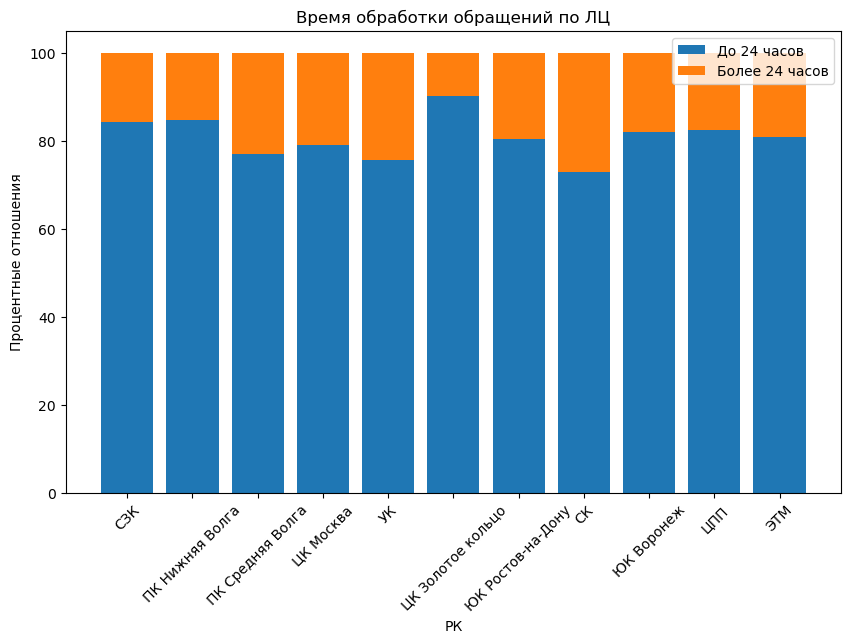

In [61]:
merged_final_result_pivot_rk = merged_final_result_pivot_rk.sort_values(by='До 24 часов', ascending=False)

merged_final_result_pivot_rk = merged_final_result_pivot_rk.sort_values(by='До 24 часов', ascending=False)
merged_final_result_pivot_rk = pd.concat([merged_final_result_pivot_rk[merged_final_result_pivot_rk['РК'] != 'ЭТМ'],
                                          merged_final_result_pivot_rk[merged_final_result_pivot_rk['РК'] == 'ЭТМ']])

total_values = merged_final_result_pivot_rk[['До 24 часов', 'Более 24 часов']].sum(axis=1)
percentage_do_24 = merged_final_result_pivot_rk['До 24 часов'] / total_values * 100
percentage_more_24 = merged_final_result_pivot_rk['Более 24 часов'] / total_values * 100

plt.figure(figsize=(10, 6))
plt.bar(merged_final_result_pivot_rk['РК'], percentage_do_24, label='До 24 часов')
plt.bar(merged_final_result_pivot_rk['РК'], percentage_more_24, bottom=percentage_do_24, label='Более 24 часов')

plt.xlabel('РК')
plt.ylabel('Процентные отношения')
plt.title('Время обработки обращений по ЛЦ')
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [62]:
final_result = final_result.drop(['РК исполнителя этапа', 'Должность исполнителя этапа', 'Описание претензии',
                                 'Исполнитель текущего этапа', 
                                  'Количество часов отработки этапа процесса', 'Текущий этап',
                                  'Дата запуска текущего этапа'], axis=1)

# Создайте объект ExcelWriter для записи данных в файл Excel
writer = pd.ExcelWriter(archive_path_final_result)
# Запишите DataFrame в файл Excel
final_result.to_excel(writer, sheet_name=f'Исходник', index=False)

# Сохраните файл Excel
writer.save()